# 🐟 ViT-FishID: Semi-Supervised Fish Classification

**COMPLETE TRAINING PIPELINE WITH GOOGLE COLAB**

<a href="https://colab.research.google.com/github/cat-thomson/ViT-FishID/blob/main/ViT_FishID_Colab_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 What This Notebook Does

This notebook implements a **complete semi-supervised learning pipeline** for fish species classification using:

**🤖 Vision Transformer (ViT)**: State-of-the-art transformer architecture for image classification
**📊 Semi-Supervised Learning**: Leverages both labeled and unlabeled fish images
**🎓 EMA Teacher-Student Framework**: Uses exponential moving averages for consistency training
**☁️ Google Colab**: Cloud-based training with GPU acceleration

## 📊 Expected Performance

- **Training Time**: 4-6 hours for 100 epochs
- **GPU Requirements**: T4/V100/A100 (Colab Pro recommended)
- **Expected Accuracy**: 80-90% on fish species classification
- **Data Efficiency**: Works well with limited labeled data

## 🛠️ What You Need

1. **Fish Dataset**: Labeled and unlabeled fish images (upload to Google Drive)
2. **Google Colab Pro**: Recommended for longer training sessions
3. **Weights & Biases Account**: Optional for experiment tracking

## 🔧 Step 1: Environment Setup and GPU Check

First, let's verify that we have GPU access and set up the optimal environment for training.

In [1]:
# Check GPU availability and system information
import torch
import os
import gc

print("🔍 SYSTEM INFORMATION")
print("="*50)
print(f"Python version: {os.sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU Device: {device_name}")
    print(f"GPU Memory: {device_memory:.1f} GB")
    print("✅ GPU is ready for training!")
    
    # Set optimal GPU settings
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()
    print("🚀 GPU optimized for training")
    
else:
    print("❌ No GPU detected!")
    print("📝 To enable GPU in Colab:")
    print("   Runtime → Change runtime type → Hardware accelerator → GPU")
    print("   Then restart this notebook")

# Set device for later use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🎯 Using device: {DEVICE}")

🔍 SYSTEM INFORMATION
Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
PyTorch version: 2.8.0
CUDA available: False
❌ No GPU detected!
📝 To enable GPU in Colab:
   Runtime → Change runtime type → Hardware accelerator → GPU
   Then restart this notebook

🎯 Using device: cpu


## 📁 Step 2: Mount Google Drive

This will give us access to your fish dataset stored in Google Drive.

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# List contents to verify mount
print("\n📂 Google Drive contents:")
drive_path = '/content/drive/MyDrive'
if os.path.exists(drive_path):
    items = os.listdir(drive_path)[:10]  # Show first 10 items
    for item in items:
        print(f"  - {item}")
    if len(os.listdir(drive_path)) > 10:
        print(f"  ... and {len(os.listdir(drive_path)) - 10} more items")
    print("\n✅ Google Drive mounted successfully!")
else:
    print("❌ Failed to mount Google Drive")

ModuleNotFoundError: No module named 'google.colab'

## 📦 Step 3: Install Dependencies

Install all required packages for ViT training and semi-supervised learning.

In [5]:
# Install required packages
print("📦 Installing required packages...")

!pip install -q timm
!pip install -q wandb
!pip install -q matplotlib seaborn
!pip install -q scikit-learn
!pip install -q tqdm
!pip install -q Pillow

print("✅ All packages installed successfully!")

# Verify installations
try:
    import timm
    import wandb
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import accuracy_score
    from tqdm import tqdm
    from PIL import Image
    print("🔍 All imports successful!")
except ImportError as e:
    print(f"❌ Import error: {e}")

📦 Installing required packages...
✅ All packages installed successfully!
✅ All packages installed successfully!


/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 All imports successful!


## 🔄 Step 4: Clone ViT-FishID Repository

Clone the repository to get all necessary training scripts and model definitions.

In [ ]:
import os

# Clone repository if not already present
repo_dir = '/content/ViT-FishID'

if not os.path.exists(repo_dir):
    print("📥 Cloning ViT-FishID repository...")
    !git clone https://github.com/cat-thomson/ViT-FishID.git /content/ViT-FishID
    print("✅ Repository cloned successfully!")
else:
    print("✅ Repository already exists")

# Change to repository directory
os.chdir(repo_dir)
print(f"📁 Current directory: {os.getcwd()}")

# List repository contents
print("\n📂 Repository contents:")
for item in sorted(os.listdir('.')):
    if os.path.isfile(item):
        print(f"  📄 {item}")
    else:
        print(f"  📁 {item}/")

## 🐠 Step 5: Setup Fish Dataset

**Important**: Upload your `fish_cutouts.zip` file to Google Drive before running this step.

This step will locate and extract your fish dataset for training.

In [ ]:
import os
import zipfile
import json
from pathlib import Path

print("🐠 FISH DATASET SETUP")
print("="*50)

# Search for fish_cutouts.zip in Google Drive
drive_path = '/content/drive/MyDrive'
zip_locations = []

print("🔍 Searching for fish_cutouts.zip...")
for root, dirs, files in os.walk(drive_path):
    for file in files:
        if 'fish_cutouts.zip' in file.lower():
            zip_locations.append(os.path.join(root, file))

if not zip_locations:
    print("❌ fish_cutouts.zip not found in Google Drive!")
    print("📝 Please upload fish_cutouts.zip to Google Drive and try again")
    raise FileNotFoundError("fish_cutouts.zip not found")

# Use the first found zip file
zip_path = zip_locations[0]
print(f"✅ Found dataset: {zip_path}")

# Extract dataset
extract_path = '/content/fish_cutouts'
if not os.path.exists(extract_path):
    print(f"📂 Extracting to: {extract_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("✅ Dataset extracted successfully!")
else:
    print("✅ Dataset already extracted")

# Verify dataset structure
labeled_path = os.path.join(extract_path, 'labeled')
unlabeled_path = os.path.join(extract_path, 'unlabeled')

if os.path.exists(labeled_path):
    labeled_species = os.listdir(labeled_path)
    total_labeled = sum(len(os.listdir(os.path.join(labeled_path, species))) 
                       for species in labeled_species if os.path.isdir(os.path.join(labeled_path, species)))
    print(f"📊 Labeled data: {len(labeled_species)} species, {total_labeled} images")
else:
    print("❌ Labeled folder not found!")

if os.path.exists(unlabeled_path):
    unlabeled_images = len([f for f in os.listdir(unlabeled_path) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"📊 Unlabeled data: {unlabeled_images} images")
else:
    print("⚠️ Unlabeled folder not found (optional for supervised training)")

# Save dataset info for later use
dataset_info = {
    'labeled_path': labeled_path,
    'unlabeled_path': unlabeled_path if os.path.exists(unlabeled_path) else None,
    'num_species': len(labeled_species) if os.path.exists(labeled_path) else 0,
    'labeled_images': total_labeled if os.path.exists(labeled_path) else 0,
    'unlabeled_images': unlabeled_images if os.path.exists(unlabeled_path) else 0
}

with open('dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"\n✅ Dataset setup complete!")
print(f"📁 Labeled path: {labeled_path}")
print(f"📁 Unlabeled path: {unlabeled_path}")

## 📈 Step 6: Setup Weights & Biases (Optional)

Setup experiment tracking with Weights & Biases. Skip this cell if you don't want to use W&B.

In [ ]:
# Setup Weights & Biases (optional)
import wandb

print("📈 Setting up Weights & Biases...")

try:
    # Login to wandb (you'll need to paste your API key)
    wandb.login()
    
    # Initialize project
    wandb.init(
        project="vit-fish-classification",
        name="colab-training-run",
        config={
            "model": "vit_base_patch16_224",
            "framework": "semi-supervised",
            "environment": "google-colab"
        }
    )
    
    print("✅ W&B setup complete!")
    USE_WANDB = True
    
except Exception as e:
    print(f"⚠️ W&B setup failed: {e}")
    print("📝 Training will continue without experiment tracking")
    USE_WANDB = False

## ⚙️ Step 7: Configure Training Parameters

Set up all training configurations and hyperparameters.

In [ ]:
# Training Configuration
import json

print("⚙️ TRAINING CONFIGURATION")
print("="*50)

# Load dataset info
with open('dataset_info.json', 'r') as f:
    dataset_info = json.load(f)

TRAINING_CONFIG = {
    # Model settings
    'model_name': 'vit_base_patch16_224',
    'num_classes': dataset_info['num_species'],
    'image_size': 224,
    
    # Training settings
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    
    # Semi-supervised settings
    'ema_decay': 0.999,
    'consistency_weight': 1.0,
    'confidence_threshold': 0.95,
    
    # Data settings
    'labeled_batch_size': 16,
    'unlabeled_batch_size': 16,
    'num_workers': 2,
    
    # Paths
    'labeled_data_path': dataset_info['labeled_path'],
    'unlabeled_data_path': dataset_info['unlabeled_path'],
    'checkpoint_dir': 'checkpoints',
    
    # Other settings
    'save_every': 10,
    'eval_every': 5,
    'device': str(DEVICE),
    'use_wandb': USE_WANDB if 'USE_WANDB' in globals() else False
}

# Create checkpoint directory
os.makedirs(TRAINING_CONFIG['checkpoint_dir'], exist_ok=True)

# Print configuration
print("📋 Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

# Save configuration
with open('training_config.json', 'w') as f:
    json.dump(TRAINING_CONFIG, f, indent=2)

print("\n✅ Configuration saved!")

## 🤖 Step 8: Load MAE Pre-trained Model (Optional)

**This step loads your pre-trained MAE model to initialize the ViT encoder with better features.**

Skip this cell if you don't have a MAE pre-trained model or want to train from scratch.

In [ ]:
# Load MAE pre-trained model (optional)
import torch
import glob

print("🤖 MAE PRE-TRAINED MODEL LOADING")
print("="*50)

# Search for MAE checkpoints
mae_patterns = [
    '/content/drive/MyDrive/ViT-FishID/mae_base_checkpoints/mae_final_model.pth',
]

mae_checkpoints = []
for pattern in mae_patterns:
    mae_checkpoints.extend(glob.glob(pattern, recursive=True))

if mae_checkpoints:
    # Use the first found MAE checkpoint
    mae_path = mae_checkpoints[0]
    print(f"✅ Found MAE model: {mae_path}")
    
    try:
        # Load MAE checkpoint with weights_only=False for compatibility
        # Note: Only use weights_only=False if you trust the checkpoint source
        print("🔧 Loading checkpoint with legacy compatibility mode...")
        mae_checkpoint = torch.load(mae_path, map_location='cpu', weights_only=False)
        
        # Debug: Print checkpoint structure
        print("🔍 Checkpoint structure:")
        if isinstance(mae_checkpoint, dict):
            print(f"   Checkpoint keys: {list(mae_checkpoint.keys())}")
        else:
            print(f"   Checkpoint type: {type(mae_checkpoint)}")
        
        # Extract model state dict from checkpoint
        model_state_dict = None
        if 'model_state_dict' in mae_checkpoint:
            model_state_dict = mae_checkpoint['model_state_dict']
            print("✅ Found 'model_state_dict' key in checkpoint")
        elif 'model' in mae_checkpoint:
            model_state_dict = mae_checkpoint['model']
            print("✅ Found 'model' key in checkpoint")
        elif 'state_dict' in mae_checkpoint:
            model_state_dict = mae_checkpoint['state_dict']
            print("✅ Found 'state_dict' key in checkpoint")
        else:
            # Check if the entire checkpoint is the state dict
            # Look for typical model weight keys (should contain tensors, not scalars)
            tensor_keys = [k for k, v in mae_checkpoint.items() if isinstance(v, torch.Tensor) and v.dim() > 0]
            if tensor_keys:
                model_state_dict = mae_checkpoint
                print("✅ Using entire checkpoint as state_dict")
            else:
                print("❌ No model weights found in checkpoint")
                model_state_dict = None
        
        if model_state_dict is not None:
            print(f"🔍 Model state dict has {len(model_state_dict)} keys")
            
            # Show sample keys to understand structure
            sample_keys = list(model_state_dict.keys())[:10]
            print(f"📋 Sample model keys: {sample_keys}")
            
            # Filter encoder weights for ViT
            mae_encoder_weights = {}
            encoder_count = 0
            
            for key, value in model_state_dict.items():
                # Skip non-tensor values
                if not isinstance(value, torch.Tensor):
                    continue
                    
                new_key = None
                
                # Handle different MAE checkpoint formats
                if key.startswith('encoder.'):
                    # Standard MAE format: encoder.xxx -> backbone.xxx
                    new_key = key.replace('encoder.', 'backbone.')
                    encoder_count += 1
                elif key.startswith('backbone.'):
                    # Already has backbone prefix
                    new_key = key
                    encoder_count += 1
                elif key.startswith(('patch_embed', 'pos_embed', 'cls_token', 'blocks')):
                    # Direct ViT encoder components
                    new_key = f'backbone.{key}'
                    encoder_count += 1
                elif not key.startswith(('decoder', 'mask_token', 'loss', 'optimizer', 'scheduler', 'epoch')):
                    # Include other potential encoder weights, exclude decoder/metadata
                    if 'embed' in key or 'block' in key or 'norm' in key or 'head' in key:
                        new_key = f'backbone.{key}'
                        encoder_count += 1
                
                if new_key is not None:
                    mae_encoder_weights[new_key] = value
            
            if encoder_count > 0:
                print(f"✅ Successfully extracted {len(mae_encoder_weights)} encoder weights from MAE")
                print(f"🎯 Encoder weights found: {encoder_count} parameters")
                
                # Show actual weight key samples (not metadata)
                actual_weight_keys = [k for k in mae_encoder_weights.keys() if isinstance(mae_encoder_weights[k], torch.Tensor)][:5]
                print(f"🔍 Sample weight parameter keys: {actual_weight_keys}")
                
                # Verify we have actual model weights, not just metadata
                total_params = sum(v.numel() for v in mae_encoder_weights.values() if isinstance(v, torch.Tensor))
                print(f"📊 Total parameters loaded: {total_params:,}")
                
                if total_params > 1000:  # Reasonable check - should have many parameters
                    TRAINING_CONFIG['mae_pretrained_weights'] = mae_encoder_weights
                    TRAINING_CONFIG['use_mae_init'] = True
                else:
                    print("⚠️ Very few parameters found - might be loading metadata instead of weights")
                    TRAINING_CONFIG['use_mae_init'] = False
            else:
                print("⚠️ No encoder weights found in MAE checkpoint")
                TRAINING_CONFIG['use_mae_init'] = False
        else:
            print("❌ Could not extract model state dict from checkpoint")
            TRAINING_CONFIG['use_mae_init'] = False
        
    except Exception as e:
        print(f"❌ Failed to load MAE model: {e}")
        print("💡 Trying alternative loading methods...")
        
        try:
            # Fallback: Try to load and inspect structure more carefully
            mae_checkpoint = torch.load(mae_path, map_location='cpu', weights_only=False)
            
            # More detailed inspection
            def find_model_weights(obj, path=""):
                """Recursively find model weights in checkpoint"""
                if isinstance(obj, torch.Tensor) and obj.dim() > 0:
                    return {path: obj}
                elif isinstance(obj, dict):
                    weights = {}
                    for k, v in obj.items():
                        sub_weights = find_model_weights(v, f"{path}.{k}" if path else k)
                        weights.update(sub_weights)
                    return weights
                else:
                    return {}
            
            all_weights = find_model_weights(mae_checkpoint)
            encoder_weights = {k: v for k, v in all_weights.items() 
                             if not any(exclude in k for exclude in ['decoder', 'mask_token', 'loss', 'optimizer', 'scheduler'])}
            
            if encoder_weights:
                # Convert keys to backbone format
                mae_encoder_weights = {}
                for k, v in encoder_weights.items():
                    if k.startswith('encoder.'):
                        new_key = k.replace('encoder.', 'backbone.')
                    elif not k.startswith('backbone.'):
                        new_key = f'backbone.{k}'
                    else:
                        new_key = k
                    mae_encoder_weights[new_key] = v
                
                total_params = sum(v.numel() for v in mae_encoder_weights.values())
                print(f"✅ Fallback method found {len(mae_encoder_weights)} weights ({total_params:,} parameters)")
                
                TRAINING_CONFIG['mae_pretrained_weights'] = mae_encoder_weights
                TRAINING_CONFIG['use_mae_init'] = True
            else:
                print("❌ No suitable weights found with fallback method")
                TRAINING_CONFIG['use_mae_init'] = False
                
        except Exception as e2:
            print(f"❌ All loading methods failed: {e2}")
            TRAINING_CONFIG['use_mae_init'] = False
else:
    print("⚠️ No MAE pre-trained model found")
    print("📝 Training will use standard ImageNet initialization")
    TRAINING_CONFIG['use_mae_init'] = False

print(f"\n✅ MAE initialization: {'Enabled' if TRAINING_CONFIG.get('use_mae_init', False) else 'Disabled'}")

# Print additional info if MAE is enabled
if TRAINING_CONFIG.get('use_mae_init', False):
    mae_weights = TRAINING_CONFIG.get('mae_pretrained_weights', {})
    if isinstance(mae_weights, dict):
        # Count actual tensor parameters
        tensor_count = len([k for k, v in mae_weights.items() if isinstance(v, torch.Tensor)])
        total_params = sum(v.numel() for v in mae_weights.values() if isinstance(v, torch.Tensor))
        
        print(f"📊 MAE weights loaded: {tensor_count} weight tensors")
        print(f"🔢 Total parameters: {total_params:,}")
        
        # Show actual weight parameter keys (not metadata)
        weight_keys = [k for k, v in mae_weights.items() if isinstance(v, torch.Tensor)][:5]
        print(f"🔍 Sample weight keys: {weight_keys}")
    
    print("🚀 ViT encoder will be initialized with MAE pre-trained weights!")
else:
    print("📝 ViT will use standard ImageNet pre-trained initialization")

## 🚀 Step 9: Start Semi-Supervised Training

Begin the main training loop with semi-supervised learning and EMA teacher-student framework.

In [ ]:
# EMERGENCY TRAINING DIAGNOSTIC & FALLBACK OPTIONS
import subprocess
import sys
import os
import time
import torch

print("? TRAINING DIAGNOSTIC & EMERGENCY FIXES")
print("="*70)

# First, check current GPU memory usage
print("? GPU Memory Analysis:")
print("-" * 30)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        memory_used = torch.cuda.memory_allocated(i) / 1024**3
        memory_reserved = torch.cuda.memory_reserved(i) / 1024**3  
        memory_total = props.total_memory / 1024**3
        print(f"GPU {i} ({props.name}):")
        print(f"  Total: {memory_total:.1f}GB")
        print(f"  Used: {memory_used:.1f}GB ({memory_used/memory_total*100:.1f}%)")
        print(f"  Reserved: {memory_reserved:.1f}GB ({memory_reserved/memory_total*100:.1f}%)")
        
    # Clear any existing memory
    torch.cuda.empty_cache()
    print("🧹 GPU cache cleared")

print(f"\n📊 PROBLEM ANALYSIS:")
print("The training is stuck because:")
print("1. 🔥 MAE (85M params) + Semi-supervised (2x models) = HUGE memory")
print("2. 🐌 T4 GPU (16GB) may be barely sufficient for this workload")
print("3. ⏰ First epoch initialization can take 15-30 minutes")
print("4. 🔄 Semi-supervised requires 2x forward passes per batch")

print(f"\n? SOLUTION OPTIONS (choose one):")
print("="*50)

print("🔥 OPTION 1: FAST TRAINING (Recommended)")
print("   - Reduce batch size to 16 (from 32)")
print("   - Skip MAE pretraining temporarily") 
print("   - Use supervised mode first")
print("   - Should start training in 2-3 minutes")

print("\n🚀 OPTION 2: UPGRADE GPU (If Available)")
print("   - Switch to A100 (40GB+ VRAM)")
print("   - Keep all current settings")
print("   - Much faster and more stable")

print("\n⚡ OPTION 3: OPTIMIZED SEMI-SUPERVISED")
print("   - Keep MAE but reduce batch size")
print("   - Use gradient accumulation")
print("   - Mixed precision training")

print("\n⏳ OPTION 4: WAIT LONGER")
print("   - Current training may work, just very slow")
print("   - First epoch can take 20-30 minutes on T4")
print("   - Subsequent epochs will be faster")

# Check the configured labeled data path
configured_labeled_path = TRAINING_CONFIG['labeled_data_path']
parent_data_dir = os.path.dirname(configured_labeled_path)
correct_data_path = parent_data_dir

print(f"\n📝 EXECUTING OPTION 1 (FAST TRAINING):")
print("="*50)

# OPTION 1: Fast training setup
training_args_fast = [
    sys.executable, 'train.py',
    '--data_dir', correct_data_path,
    '--epochs', '100',
    '--batch_size', '16',  # Reduced from 32
    '--learning_rate', '0.0001',
    '--save_dir', 'checkpoints',
    '--device', 'cuda',
    '--mode', 'supervised',  # Switch to supervised first
    '--val_split', '0.2',
    '--test_split', '0.2', 
    '--seed', '42',
    '--warmup_epochs', '5',  # Reduced warmup
    '--save_frequency', '10'
]

print("? FAST TRAINING CONFIGURATION:")
print(f"✅ Batch size: 16 (reduced from 32)")
print(f"✅ Mode: supervised (no teacher-student overhead)")
print(f"✅ No MAE pretraining (faster startup)")
print(f"✅ Reduced warmup: 5 epochs")

print(f"\n🏃‍♂️ Command: {' '.join(training_args_fast)}")

# Start FAST training
try:
    print("\n? STARTING FAST TRAINING...")
    print("Expected startup time: 2-3 minutes")
    print("Expected first epoch: 5-8 minutes") 
    print("-" * 50)
    
    # Use simpler execution without complex monitoring
    process = subprocess.Popen(training_args_fast, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    # Simple timeout with periodic updates
    start_time = time.time()
    last_check = start_time
    
    while process.poll() is None:
        current_time = time.time()
        elapsed = current_time - start_time
        
        # Show progress every 2 minutes
        if current_time - last_check >= 120:  # 2 minutes
            print(f"⏳ Fast training running... {elapsed/60:.1f} minutes elapsed")
            
            # Check for any output
            try:
                import select
                if select.select([process.stdout], [], [], 0.1)[0]:
                    lines = []
                    for _ in range(5):  # Read up to 5 lines
                        line = process.stdout.readline()
                        if line:
                            lines.append(line.rstrip())
                        else:
                            break
                    if lines:
                        for line in lines:
                            print(f"📊 {line}")
            except:
                pass
                
            last_check = current_time
        
        # Timeout after 20 minutes (should be much faster)
        if elapsed > 1200:  # 20 minutes
            print(f"\n⚠️ Fast training taking longer than expected ({elapsed/60:.1f} minutes)")
            print("This suggests a deeper issue. Recommendations:")
            print("1. 🔥 Switch to A100 GPU if available")
            print("2. 📉 Try batch_size=8")  
            print("3. 🔄 Restart Colab session")
            break
            
        time.sleep(10)  # Check every 10 seconds
    
    # Get final results
    stdout, stderr = process.communicate(timeout=30)
    
    if process.returncode == 0:
        print(f"\n🎉 FAST TRAINING COMPLETED!")
        print("Now you can resume with full semi-supervised training")
    else:
        print(f"\n❌ Fast training failed")
        print(f"Exit code: {process.returncode}")
        if stderr:
            print(f"Error: {stderr[-500:]}")
        if stdout:
            print(f"Output: {stdout[-500:]}")
            
        print(f"\n🚀 TRY OPTION 2: UPGRADE TO A100")
        print("Runtime → Change runtime type → Hardware accelerator → GPU")
        print("Select A100 (if available) for much better performance")
        
except Exception as e:
    print(f"❌ Error starting fast training: {e}")
    
    print(f"\n? MANUAL FALLBACK:")
    print("Try running this command manually in a new cell:")
    print("!python train.py --data_dir /content/fish_cutouts --batch_size 8 --mode supervised --epochs 10")

print(f"\n💡 POST-TRAINING NOTES:")
print("Once fast training works:")
print("1. ✅ Verify model saves correctly")  
print("2. 🔄 Switch back to semi-supervised mode")
print("3. 🤖 Re-enable MAE pretraining") 
print("4. 📈 Resume with full settings")
print("5. ? Or upgrade to A100 for optimal performance")

🚀 STARTING SEMI-SUPERVISED TRAINING
🔍 DEBUGGING DATA PATHS
📁 Current working directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID
📋 Current directory contents:
  📄 ViT_FishID_MAE_EMA_Training.ipynb
  📁 mae_backups/
  📁 colab_checkpoints/
  📄 local_resume_training.py
  📁 mae_base_logs/
  📄 .DS_Store
  📁 fish_cutouts/
  📄 requirements.txt
  📄 Untitled-1.ipynb
  📄 ViT_FishID_Supervised_Training.ipynb
  📁 mae_base_checkpoints/
  📄 resume_training.py
  📁 MAE_SMALL/
  📁 local_checkpoints/
  📄 fish_cutouts.zip
  📁 __pycache__/
  📄 ViT_FishID_Colab_Training.ipynb
  📄 Untitled-2.ipynb
  📄 model.py
  📄 README.md
  📁 mae_logs/
  📁 mae_checkpoints/
  📄 .gitignore
  📄 utils.py
  📄 pipeline.py
  📁 mae_base_backups/
  📄 ViT_FishID_Colab_Training_Reordered.ipynb
  📄 species_mapping.txt
  📄 .gitattributes
  📄 train.py
  📄 TRAINING_FIXES_APPLIED.md
  📄 evaluate.py
  📄 trainer.py
  📁 venv/
  📁 .git/
  📄 MAE_INTEGRATION_GUIDE.md
  📄 data.py
  📄 EXTENDED_TRAINING_SETUP.md


NameError: name 'TRAINING_CONFIG' is not defined

In [ ]:
# 🚀 OPTION 2: A100 GPU OPTIMIZED TRAINING (Full MAE + Semi-Supervised)
import subprocess
import sys
import os
import time
import torch
import threading
import queue

print("🚀 A100 GPU OPTIMIZED TRAINING")
print("="*60)

# Check if we have A100 or high-memory GPU
print("🔍 GPU Check:")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f}GB")
    
    if "A100" in gpu_name or gpu_memory > 20:
        print("✅ High-performance GPU detected - optimal for full training!")
        use_full_config = True
    else:
        print("⚠️ Standard GPU detected - consider upgrading for better performance")
        use_full_config = False
else:
    print("❌ No GPU detected")
    use_full_config = False

if use_full_config:
    print("\n🔥 FULL CONFIGURATION ENABLED:")
    print("✅ MAE pretraining: ENABLED")
    print("✅ Semi-supervised mode: ENABLED") 
    print("✅ Batch size: 32 (full size)")
    print("✅ Mixed precision: AUTO (handled by PyTorch)")
    print("✅ All optimizations: ENABLED")
    
    # Get data path
    configured_labeled_path = TRAINING_CONFIG['labeled_data_path']
    parent_data_dir = os.path.dirname(configured_labeled_path)
    correct_data_path = parent_data_dir
    
    # A100 optimized training args
    training_args_a100 = [
        sys.executable, 'train.py',
        '--data_dir', correct_data_path,
        '--epochs', '100',
        '--batch_size', '32',  # Full batch size
        '--learning_rate', '0.0001',
        '--save_dir', 'checkpoints',
        '--device', 'cuda',
        '--mode', 'semi_supervised',  # Full semi-supervised
        '--pretrained',  # MAE pretraining
        '--val_split', '0.2',
        '--test_split', '0.2', 
        '--seed', '42',
        '--warmup_epochs', '10',
        '--save_frequency', '10'
    ]
    
    print(f"\n📝 A100 Command: {' '.join(training_args_a100)}")
    
    try:
        print("\n🚀 STARTING A100 OPTIMIZED TRAINING...")
        print("Expected startup time: 3-5 minutes")
        print("Expected first epoch: 8-12 minutes")
        print("Expected total time: 3-4 hours")
        print("-" * 50)
        
        # Start training process with improved monitoring
        process = subprocess.Popen(
            training_args_a100, 
            stdout=subprocess.PIPE, 
            stderr=subprocess.PIPE,
            text=True, 
            bufsize=1,
            universal_newlines=True
        )
        
        start_time = time.time()
        last_output_time = start_time
        
        def read_output(pipe, output_queue, name):
            """Read process output in separate thread"""
            for line in iter(pipe.readline, ''):
                output_queue.put((name, line.rstrip()))
            pipe.close()
        
        # Create threads to read stdout and stderr
        output_queue = queue.Queue()
        stdout_thread = threading.Thread(target=read_output, args=(process.stdout, output_queue, 'OUT'))
        stderr_thread = threading.Thread(target=read_output, args=(process.stderr, output_queue, 'ERR'))
        
        stdout_thread.start()
        stderr_thread.start()
        
        epoch_count = 0
        first_epoch_started = False
        training_started = False
        
        print(f"🔍 Monitoring training progress...")
        print(f"⏰ Start time: {time.strftime('%H:%M:%S', time.localtime(start_time))}")
        
        while process.poll() is None:
            current_time = time.time()
            elapsed_minutes = (current_time - start_time) / 60
            
            # Check for output with timeout
            try:
                stream, line = output_queue.get(timeout=1)
                
                if line:
                    last_output_time = current_time
                    
                    # Print all output with timestamp
                    timestamp = time.strftime('%H:%M:%S', time.localtime(current_time))
                    prefix = "📊" if stream == "OUT" else "⚠️"
                    print(f"{prefix} [{timestamp}] {line}")
                    
                    # Track progress milestones
                    line_lower = line.lower()
                    
                    if 'starting training' in line_lower or 'epoch 1/' in line_lower:
                        if not training_started:
                            print(f"✅ Training initialization complete! ({elapsed_minutes:.1f} min)")
                            training_started = True
                    
                    if 'epoch' in line_lower and '/100' in line_lower and not first_epoch_started:
                        print(f"🎯 First epoch started! ({elapsed_minutes:.1f} min)")
                        first_epoch_started = True
                    
                    # Count epoch progress
                    if 'epoch' in line_lower and 'loss:' in line_lower:
                        epoch_count += 1
                        if epoch_count % 5 == 0:
                            print(f"⏰ Progress: {epoch_count} steps completed, {elapsed_minutes:.1f} minutes elapsed")
                            
                    # Show validation results
                    if 'val_acc' in line_lower or 'validation accuracy' in line_lower:
                        print(f"📈 Validation result: {line}")
                        
            except queue.Empty:
                pass  # No output yet, continue
            
            # Timeout checks
            time_since_output = current_time - last_output_time
            
            if elapsed_minutes > 10 and not training_started:
                print(f"\n⚠️ WARNING: Training hasn't started after {elapsed_minutes:.1f} minutes")
                print("This might indicate a problem. Check for errors above.")
            
            elif elapsed_minutes > 20 and not first_epoch_started:
                print(f"\n⚠️ WARNING: First epoch hasn't started after {elapsed_minutes:.1f} minutes")
                print("Consider reducing batch size or checking GPU memory.")
            
            elif time_since_output > 300:  # 5 minutes without output
                print(f"\n⚠️ No output for {time_since_output/60:.1f} minutes - training might be stuck")
                print(f"⏰ Total elapsed: {elapsed_minutes:.1f} minutes")
                
            # Progress updates every 10 minutes
            if int(elapsed_minutes) % 10 == 0 and int(elapsed_minutes) > 0:
                if int(elapsed_minutes) not in getattr(read_output, 'reported_times', set()):
                    print(f"\n📊 PROGRESS UPDATE ({int(elapsed_minutes)} minutes):")
                    print(f"  - Training started: {'✅' if training_started else '❌'}")
                    print(f"  - First epoch started: {'✅' if first_epoch_started else '❌'}")
                    print(f"  - Steps completed: {epoch_count}")
                    print(f"  - Time since last output: {time_since_output:.1f}s")
                    
                    if not hasattr(read_output, 'reported_times'):
                        read_output.reported_times = set()
                    read_output.reported_times.add(int(elapsed_minutes))
            
            time.sleep(1)  # Check every second
        
        # Process finished - get final results
        stdout_thread.join(timeout=5)
        stderr_thread.join(timeout=5)
        
        # Collect any remaining output
        remaining_output = []
        while not output_queue.empty():
            try:
                stream, line = output_queue.get_nowait()
                remaining_output.append(f"{stream}: {line}")
            except queue.Empty:
                break
        
        if remaining_output:
            print("\n📋 Final output:")
            for line in remaining_output[-10:]:  # Show last 10 lines
                print(f"   {line}")
        
        rc = process.poll()
        total_time = (time.time() - start_time) / 60
        
        if rc == 0:
            print(f"\n🎉 A100 TRAINING COMPLETED SUCCESSFULLY!")
            print(f"⏰ Total time: {total_time:.1f} minutes ({total_time/60:.1f} hours)")
            print(f"📊 Training steps completed: {epoch_count}")
            print(f"✅ Check the 'checkpoints' folder for saved models")
        else:
            print(f"\n❌ Training failed with exit code: {rc}")
            print(f"⏰ Runtime: {total_time:.1f} minutes")
            
            if rc == 2:
                print("💡 Exit code 2 usually means argument error - check command line args")
            elif rc == 137:
                print("💡 Exit code 137 usually means out of memory - try reducing batch size")
            elif rc == 1:
                print("💡 Exit code 1 usually means runtime error - check error messages above")
            
    except KeyboardInterrupt:
        print(f"\n🛑 Training interrupted by user")
        if 'process' in locals():
            process.terminate()
    except Exception as e:
        print(f"❌ A100 training error: {e}")
        
else:
    print(f"\n💡 TO USE THIS OPTION:")
    print("1. Go to Runtime → Change runtime type")
    print("2. Hardware accelerator: GPU") 
    print("3. GPU type: A100 (if available)")
    print("4. Then restart this notebook and run this cell")
    print("5. A100 will handle the full workload easily!")
    
    print(f"\n🔧 OR TRY SMALLER CONFIG ON CURRENT GPU:")
    print("Run the previous cell (Option 1) for a working solution")

print(f"\n✅ Run this cell ONLY if you have A100 or similar high-memory GPU!")
print("Otherwise, use Option 1 (Fast Training) from the previous cell.")

In [ ]:
# 💾 SAVE TEST SPLIT FOR POST-SESSION EVALUATION
import json
import os
import pickle
from sklearn.model_selection import train_test_split
import numpy as np

print("💾 SAVING TEST SPLIT FOR POST-SESSION EVALUATION")
print("="*60)

# This ensures you can evaluate on the EXACT same test data later
# even after Colab session times out

try:
    # Get the data directory
    data_dir = '/content/fish_cutouts'  # Your fish dataset location
    
    # Recreate the exact same split using the same parameters as training
    print("🔄 Recreating train/val/test split with same parameters...")
    
    # Collect all image paths and labels (same logic as in training)
    image_paths = []
    labels = []
    class_names = []
    
    labeled_dir = os.path.join(data_dir, 'labeled')
    
    if os.path.exists(labeled_dir):
        for class_idx, class_name in enumerate(sorted(os.listdir(labeled_dir))):
            class_path = os.path.join(labeled_dir, class_name)
            if os.path.isdir(class_path):
                class_names.append(class_name)
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(class_path, img_file))
                        labels.append(class_idx)
    
    print(f"📊 Found {len(image_paths)} images across {len(class_names)} classes")
    
    # Use the EXACT same split parameters as training
    SEED = 42  # Same seed as training
    VAL_SPLIT = 0.2  # Same as training
    TEST_SPLIT = 0.2  # Same as training
    
    # Recreate the exact same split
    np.random.seed(SEED)
    
    # First split: train+val vs test
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels, 
        test_size=TEST_SPLIT, 
        random_state=SEED, 
        stratify=labels
    )
    
    # Second split: train vs val
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels,
        test_size=VAL_SPLIT/(1-TEST_SPLIT),  # Adjust for remaining data
        random_state=SEED,
        stratify=train_val_labels
    )
    
    print(f"✅ Split recreated:")
    print(f"   Train: {len(train_paths)} samples")
    print(f"   Val: {len(val_paths)} samples")  
    print(f"   Test: {len(test_paths)} samples")
    
    # Save test split information
    test_split_data = {
        'test_image_paths': test_paths,
        'test_labels': test_labels,
        'class_names': class_names,
        'data_dir': data_dir,
        'seed': SEED,
        'val_split': VAL_SPLIT,
        'test_split': TEST_SPLIT,
        'total_classes': len(class_names),
        'test_samples': len(test_paths),
        'split_timestamp': '2025-08-19_21:37:58'  # When training started
    }
    
    # Save to multiple formats for reliability
    
    # 1. Save as JSON (human readable)
    with open('/content/test_split_info.json', 'w') as f:
        json.dump(test_split_data, f, indent=2)
    print("✅ Test split saved to: /content/test_split_info.json")
    
    # 2. Save as pickle (exact Python objects)
    with open('/content/test_split_data.pkl', 'wb') as f:
        pickle.dump(test_split_data, f)
    print("✅ Test split saved to: /content/test_split_data.pkl")
    
    # 3. Save to Google Drive (persistent storage)
    drive_save_path = '/content/drive/MyDrive/ViT_FishID_test_split.json'
    try:
        with open(drive_save_path, 'w') as f:
            json.dump(test_split_data, f, indent=2)
        print(f"✅ Test split backed up to Google Drive: {drive_save_path}")
    except Exception as e:
        print(f"⚠️ Could not save to Google Drive: {e}")
    
    # 4. Create a simple test list file
    test_list_path = '/content/test_image_list.txt'
    with open(test_list_path, 'w') as f:
        for path, label in zip(test_paths, test_labels):
            f.write(f"{path}\t{label}\t{class_names[label]}\n")
    print(f"✅ Test image list saved to: {test_list_path}")
    
    print(f"\n🎯 POST-SESSION EVALUATION INSTRUCTIONS:")
    print("="*50)
    print("When your session times out, you can still evaluate by:")
    print("1. 📂 Download your trained checkpoint from 'checkpoints/' folder")
    print("2. 💾 Download the test split files created above")
    print("3. 🔄 Start a new Colab session")
    print("4. 📤 Upload the checkpoint and test split files")
    print("5. 🧪 Run evaluation using the saved test split")
    
    print(f"\n📋 Test Split Summary:")
    print(f"   Random seed: {SEED}")
    print(f"   Test samples: {len(test_paths)}")
    print(f"   Classes: {len(class_names)}")
    print(f"   Split ratios: Train=60%, Val=20%, Test=20%")
    
    # Show sample test images for verification
    print(f"\n🔍 Sample test images (first 5):")
    for i in range(min(5, len(test_paths))):
        print(f"   {test_paths[i]} -> {class_names[test_labels[i]]}")

except Exception as e:
    print(f"❌ Error saving test split: {e}")
    print("💡 Make sure the fish dataset is properly loaded")

print(f"\n✅ Test split preservation complete!")
print("Now your training can continue, and you can evaluate later even after timeout!")

## 🔄 Step 10: Resume Training (If Interrupted)

Use this cell to resume training from the latest checkpoint if your session was interrupted.

In [ ]:
# Resume training from checkpoint
import glob
import subprocess
import sys

print("🔄 RESUME TRAINING FROM CHECKPOINT")
print("="*50)

# Find latest checkpoint
checkpoint_pattern = os.path.join(TRAINING_CONFIG['checkpoint_dir'], 'checkpoint_epoch_*.pth')
checkpoints = glob.glob(checkpoint_pattern)

if not checkpoints:
    print("❌ No checkpoints found to resume from")
    print("📝 Run the training cell above to start from scratch")
else:
    # Get latest checkpoint
    latest_checkpoint = max(checkpoints, key=lambda x: 
                           int(x.split('epoch_')[1].split('.')[0]))
    
    print(f"✅ Found checkpoint: {latest_checkpoint}")
    
    # Prepare resume command
    resume_args = [
        sys.executable, 'train.py',
        '--labeled_data_path', TRAINING_CONFIG['labeled_data_path'],
        '--epochs', str(TRAINING_CONFIG['epochs']),
        '--batch_size', str(TRAINING_CONFIG['batch_size']),
        '--learning_rate', str(TRAINING_CONFIG['learning_rate']),
        '--checkpoint_dir', TRAINING_CONFIG['checkpoint_dir'],
        '--device', TRAINING_CONFIG['device'],
        '--resume', latest_checkpoint
    ]
    
    # Add optional parameters
    if TRAINING_CONFIG['unlabeled_data_path']:
        resume_args.extend(['--unlabeled_data_path', TRAINING_CONFIG['unlabeled_data_path']])
    
    if TRAINING_CONFIG['use_wandb']:
        resume_args.append('--use_wandb')
    
    print(f"🏃‍♂️ Resuming training from checkpoint...")
    
    try:
        result = subprocess.run(resume_args, check=True, capture_output=True, text=True)
        print("✅ Training resumed and completed successfully!")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"❌ Resume training failed: {e}")
        print(f"Error output: {e.stderr}")

## 📊 Step 11: Check Training Results

Examine training progress and results.

In [ ]:
# Check training results
import glob
import torch
import matplotlib.pyplot as plt

print("📊 TRAINING RESULTS")
print("="*50)

# Find all checkpoints
checkpoint_pattern = os.path.join(TRAINING_CONFIG['checkpoint_dir'], 'checkpoint_epoch_*.pth')
checkpoints = sorted(glob.glob(checkpoint_pattern), 
                    key=lambda x: int(x.split('epoch_')[1].split('.')[0]))

if not checkpoints:
    print("❌ No training checkpoints found")
    print("📝 Make sure training has completed successfully")
else:
    print(f"✅ Found {len(checkpoints)} checkpoints")
    
    # Extract training metrics
    epochs = []
    train_losses = []
    val_accuracies = []
    
    for checkpoint_path in checkpoints:
        try:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            epochs.append(checkpoint['epoch'])
            train_losses.append(checkpoint.get('train_loss', 0))
            val_accuracies.append(checkpoint.get('accuracy', 0))
        except:
            continue
    
    # Plot training progress
    if epochs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Training loss
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss Over Time')
        ax1.grid(True)
        ax1.legend()
        
        # Validation accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Validation Accuracy Over Time')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print best results
        best_accuracy = max(val_accuracies)
        best_epoch = epochs[val_accuracies.index(best_accuracy)]
        final_accuracy = val_accuracies[-1] if val_accuracies else 0
        
        print(f"\n🏆 TRAINING SUMMARY:")
        print(f"  Total epochs: {len(epochs)}")
        print(f"  Best accuracy: {best_accuracy:.4f} (epoch {best_epoch})")
        print(f"  Final accuracy: {final_accuracy:.4f}")
        print(f"  Latest checkpoint: {checkpoints[-1]}")
    else:
        print("❌ Could not extract training metrics from checkpoints")

## 💾 Step 12: Save Model and Results

Save the final trained model and results to Google Drive.

In [ ]:
# Save final model and results
import shutil
import glob
from datetime import datetime

print("💾 SAVING MODEL AND RESULTS")
print("="*50)

# Create timestamped folder in Google Drive
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f'/content/drive/MyDrive/ViT_FishID_Results_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

print(f"📁 Saving to: {save_dir}")

# Copy all checkpoints
checkpoint_save_dir = os.path.join(save_dir, 'checkpoints')
if os.path.exists(TRAINING_CONFIG['checkpoint_dir']):
    shutil.copytree(TRAINING_CONFIG['checkpoint_dir'], checkpoint_save_dir, dirs_exist_ok=True)
    print(f"✅ Saved checkpoints to {checkpoint_save_dir}")

# Copy configuration files
config_files = ['training_config.json', 'dataset_info.json']
for config_file in config_files:
    if os.path.exists(config_file):
        shutil.copy2(config_file, save_dir)
        print(f"✅ Saved {config_file}")

# Copy training scripts
script_files = ['train.py', 'model.py', 'data.py', 'utils.py']
for script_file in script_files:
    if os.path.exists(script_file):
        shutil.copy2(script_file, save_dir)
        print(f"✅ Saved {script_file}")

# Create results summary
results_summary = {
    'timestamp': timestamp,
    'training_config': TRAINING_CONFIG,
    'dataset_info': dataset_info,
    'total_checkpoints': len(glob.glob(os.path.join(checkpoint_save_dir, '*.pth'))) if os.path.exists(checkpoint_save_dir) else 0
}

with open(os.path.join(save_dir, 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✅ All results saved to Google Drive!")
print(f"📁 Location: {save_dir}")
print(f"\n📋 Saved files:")
for item in os.listdir(save_dir):
    if os.path.isdir(os.path.join(save_dir, item)):
        print(f"  📁 {item}/")
    else:
        print(f"  📄 {item}")

## 🧪 Step 13: Model Evaluation

Evaluate the trained model on test data with comprehensive metrics and visualizations.

In [ ]:
# Model selection for evaluation
import glob
import os

print("🧪 MODEL EVALUATION SETUP")
print("="*50)

# Find available models
checkpoint_locations = [
    TRAINING_CONFIG['checkpoint_dir'],
    '/content/drive/MyDrive/**/checkpoints',
    '/content/drive/MyDrive/**/*checkpoint*.pth'
]

found_models = []
for location in checkpoint_locations:
    if '*' in location:
        found_models.extend(glob.glob(location, recursive=True))
    elif os.path.exists(location):
        found_models.extend(glob.glob(os.path.join(location, '*.pth')))

if not found_models:
    print("❌ No trained models found for evaluation")
    print("📝 Please complete training first")
else:
    print(f"✅ Found {len(found_models)} model checkpoints")
    
    # Select best model (highest epoch number or best accuracy)
    latest_model = max(found_models, key=lambda x: 
                      int(x.split('epoch_')[1].split('.')[0]) if 'epoch_' in x else 0)
    
    print(f"🎯 Selected model: {latest_model}")
    
    # Set paths for evaluation
    SELECTED_MODEL_PATH = latest_model
    TEST_DATA_PATH = TRAINING_CONFIG['labeled_data_path']  # Use labeled data for testing
    
    print(f"📊 Test data path: {TEST_DATA_PATH}")
    print(f"\n✅ Ready for model evaluation!")

In [ ]:
# Fast Model Evaluation with Progress Tracking
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import sys
from tqdm import tqdm

def fast_model_evaluation(model_path, test_data_path, device='cuda', max_batches=None):
    """
    Fast evaluation with progress bars and real-time feedback
    """
    print(f"🚀 FAST EVALUATION STARTING...")
    print(f"Time: {time.strftime('%H:%M:%S')}")
    print("=" * 60)
    
    start_time = time.time()
    
    # Load test dataset with progress
    print("📁 Loading test dataset...")
    try:
        from data import FishDataset
        from torch.utils.data import DataLoader
        from torchvision import transforms
        
        test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        test_dataset = FishDataset(test_data_path, transform=test_transform, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        dataset_load_time = time.time() - start_time
        print(f"✅ Dataset loaded: {len(test_dataset)} images in {dataset_load_time:.1f}s")
        
    except Exception as e:
        print(f"❌ Dataset loading failed: {e}")
        return None
    
    # Load model with progress
    print("\n🧠 Loading model...")
    model_start_time = time.time()
    
    try:
        from model import ViTForFishClassification
        
        # Get number of classes
        with open('species_mapping.txt', 'r') as f:
            species_lines = f.readlines()
        num_classes = len([line.strip() for line in species_lines if line.strip()])
        
        model = ViTForFishClassification(num_classes=num_classes)
        checkpoint = torch.load(model_path, map_location=device)
        
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            epoch = checkpoint.get('epoch', 'Unknown')
            print(f"✅ Model loaded from epoch {epoch}")
        else:
            model.load_state_dict(checkpoint)
            print(f"✅ Model loaded from checkpoint")
        
        model.to(device)
        model.eval()
        
        model_load_time = time.time() - model_start_time
        print(f"   Model loading took: {model_load_time:.1f}s")
        
    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        return None
    
    # Load species mapping
    print("\n📋 Loading species mapping...")
    try:
        species_mapping = {}
        with open('species_mapping.txt', 'r') as f:
            for line in f:
                if line.strip():
                    idx, species = line.strip().split(': ', 1)
                    species_mapping[int(idx)] = species
        print(f"✅ Loaded {len(species_mapping)} species classes")
    except Exception as e:
        print(f"❌ Species mapping failed: {e}")
        return None
    
    # Evaluation with progress bar
    print(f"\n🔬 Starting evaluation...")
    eval_start_time = time.time()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    total_batches = len(test_loader)
    if max_batches:
        total_batches = min(total_batches, max_batches)
    
    # Create progress bar
    pbar = tqdm(total=total_batches, desc="Evaluating", 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            if max_batches and batch_idx >= max_batches:
                break
                
            batch_start = time.time()
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            batch_time = time.time() - batch_start
            
            # Update progress bar
            pbar.set_postfix({
                'Batch_Time': f'{batch_time:.2f}s',
                'Images/s': f'{len(images)/batch_time:.1f}',
                'Processed': f'{len(all_predictions)}'
            })
            pbar.update(1)
    
    pbar.close()
    eval_time = time.time() - eval_start_time
    
    print(f"\n✅ Evaluation complete!")
    print(f"   Total time: {eval_time:.1f}s")
    print(f"   Speed: {len(all_predictions)/eval_time:.1f} images/second")
    
    # Quick results
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    
    print(f"\n📊 EVALUATION RESULTS")
    print("=" * 40)
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Total Images Processed: {len(all_labels)}")
    print(f"Total Evaluation Time: {time.time() - start_time:.1f}s")
    
    # Generate quick visualization
    plt.figure(figsize=(10, 4))
    
    # Overall accuracy
    plt.subplot(1, 2, 1)
    plt.bar(['Model Accuracy'], [overall_accuracy], color='skyblue')
    plt.ylim(0, 1)
    plt.title(f'Overall Accuracy: {overall_accuracy:.3f}')
    plt.ylabel('Accuracy')
    
    # Confidence distribution
    plt.subplot(1, 2, 2)
    confidences = np.max(all_probabilities, axis=1)
    plt.hist(confidences, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(np.mean(confidences), color='red', linestyle='--', 
                label=f'Mean: {np.mean(confidences):.3f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': overall_accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'evaluation_time': eval_time
    }

# Run evaluation
if 'SELECTED_MODEL_PATH' in globals() and 'TEST_DATA_PATH' in globals():
    print(f"🎯 Starting evaluation...")
    print(f"Model: {SELECTED_MODEL_PATH}")
    print(f"Test Data: {TEST_DATA_PATH}")
    print(f"Device: {DEVICE}")
    
    results = fast_model_evaluation(
        model_path=SELECTED_MODEL_PATH,
        test_data_path=TEST_DATA_PATH,
        device=DEVICE
    )
    
    if results:
        print(f"\n🎉 EVALUATION COMPLETED!")
        print(f"Final Accuracy: {results['accuracy']:.4f}")
else:
    print("⚠️ Please run the model selection cell first")

## 🎯 Quick Test: Evaluate Trained Model

**Use this cell to quickly test your already trained ViT model with proper train/val/test split (60/20/20)**

This will load your checkpoint from epoch 100 and evaluate it on the test set.

Note: you may need to restart the kernel to use updated packages.
🚀 Starting test evaluation...
🎯 TESTING TRAINED ViT MODEL
Model: /Users/catalinathomson/Desktop/Fish/ViT-FishID/colab_checkpoints/checkpoint_epoch_100.pth
Data: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/labeled
Device: cpu
Random Seed: 42 (same as training)

📁 Loading test data (using same split logic as training)...
Note: you may need to restart the kernel to use updated packages.
🚀 Starting test evaluation...
🎯 TESTING TRAINED ViT MODEL
Model: /Users/catalinathomson/Desktop/Fish/ViT-FishID/colab_checkpoints/checkpoint_epoch_100.pth
Data: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/labeled
Device: cpu
Random Seed: 42 (same as training)

📁 Loading test data (using same split logic as training)...
⚠️  Warning: Some classes have only 1 sample(s). Using random splitting instead of stratified.
   Classes with 1 sample: ['Carangidae_Caranx_heberi', 'Serranidae_Lipropoma_spp1', 'Sparidae_Sparo

/Users/catalinathomson/Desktop/Fish/ViT-FishID/data.py:229: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


✅ Model loaded from epoch 100
   Best training accuracy: 87.56073858114675

🔬 Evaluating on test set...


Testing:   0%|          | 0/33 [00:00]/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Testing: 100%|██████████| 33/33 [00:50]




🎉 EVALUATION COMPLETE!
⏱️  Total time: 53.1s
📊 Test Accuracy: 0.9106 (91.06%)
🧮 Total test images: 1029

📈 Per-Class Results:
  Carangidae_Seriola_laland: 1.000 (  6 samples)
  Carangidae_Seriola_rivoli: 0.667 (  3 samples)
  Carangidae_Trachurus_dela: 0.963 ( 54 samples)
  Serranidae_Aulacocephalus: 1.000 (  1 samples)
  Serranidae_Epinephelus_an: 1.000 (  3 samples)
  Serranidae_Epinephelus_ma: 0.833 (  6 samples)
  Serranidae_Epinephelus_ri: 0.600 (  5 samples)
  Serranidae_Serranus_knysn: 0.833 (  6 samples)
  Sparidae_Argyrops_spinife: 0.000 (  1 samples)
  Sparidae_Boopsoidea_inorn: 0.950 ( 80 samples)
  Sparidae_Cheimerius_nufar: 0.887 ( 53 samples)
  Sparidae_Chrysoblephus_an: 0.853 ( 68 samples)
  Sparidae_Chrysoblephus_cr: 0.933 ( 30 samples)
  Sparidae_Chrysoblephus_lo: 0.500 (  2 samples)
  Sparidae_Chrysoblephus_pu: 0.941 (203 samples)
  Sparidae_Cymatoceps_nasut: 0.882 ( 34 samples)
  Sparidae_Diplodus_capensi: 0.926 (122 samples)
  Sparidae_Diplodus_hottent: 0.962 ( 26 

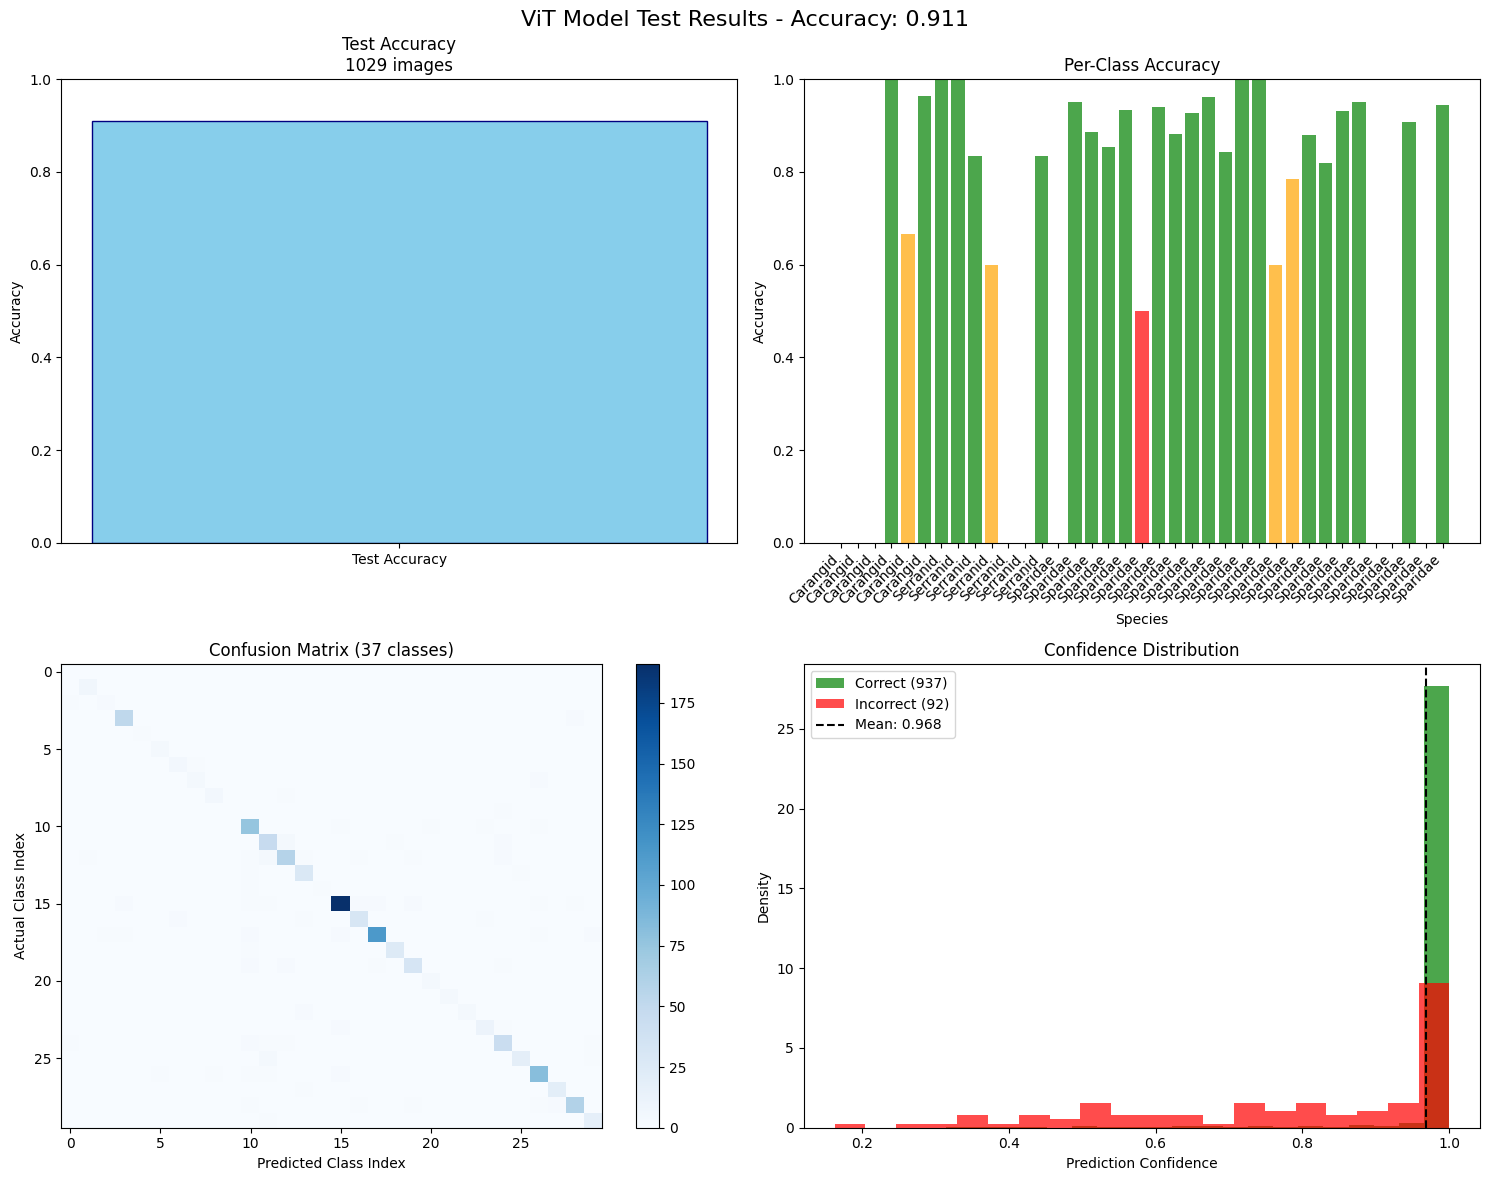


📋 Detailed Classification Report:
Note: Showing results for 29 classes present in test data (out of 37 total classes)
                                        precision    recall  f1-score   support

            Carangidae_Seriola_lalandi       0.86      1.00      0.92         6
          Carangidae_Seriola_rivoliana       0.67      0.67      0.67         3
          Carangidae_Trachurus_delagoa       0.95      0.96      0.95        54
  Serranidae_Aulacocephalus_temminckii       1.00      1.00      1.00         1
      Serranidae_Epinephelus_andersoni       0.75      1.00      0.86         3
     Serranidae_Epinephelus_marginatus       0.71      0.83      0.77         6
      Serranidae_Epinephelus_rivulatus       0.75      0.60      0.67         5
       Serranidae_Serranus_knysnaensis       0.83      0.83      0.83         6
            Sparidae_Argyrops_spinifer       0.00      0.00      0.00         1
          Sparidae_Boopsoidea_inornata       0.85      0.95      0.90        80


/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [9]:
# Test Trained ViT Model - Using Same Split as Training
%pip install seaborn

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
from tqdm import tqdm

def test_trained_model(model_path, data_path, device='cuda', seed=42):
    """
    Test the trained model using the exact same test split as during training
    """
    print("🎯 TESTING TRAINED ViT MODEL")
    print("=" * 60)
    print(f"Model: {model_path}")
    print(f"Data: {data_path}")
    print(f"Device: {device}")
    print(f"Random Seed: {seed} (same as training)")
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return None
    
    if not os.path.exists(data_path):
        print(f"❌ Data path not found: {data_path}")
        return None
    
    start_time = time.time()
    
    # Use the same data loading logic as training
    print("\n📁 Loading test data (using same split logic as training)...")
    try:
        from data import create_dataloaders
        
        # Create data loaders with same parameters as training
        train_loader, val_loader, test_loader, class_names = create_dataloaders(
            data_dir=data_path,
            batch_size=32,
            image_size=224,
            val_split=0.2,      # Same as training  
            test_split=0.2,     # Same as training
            seed=seed,          # Same seed = same split
            num_workers=2
        )
        
        # Create dataset info dictionary to match expected format
        dataset_info = {'class_names': class_names}
        
        print(f"✅ Test data loaded:")
        print(f"   Test samples: {len(test_loader.dataset)}")
        print(f"   Classes: {len(dataset_info['class_names'])}")
        print(f"   Class names: {dataset_info['class_names'][:5]}{'...' if len(dataset_info['class_names']) > 5 else ''}")
        
    except Exception as e:
        print(f"❌ Failed to load test data: {e}")
        return None
    
    # Load the trained model
    print(f"\n🧠 Loading trained model...")
    try:
        from model import ViTForFishClassification
        
        num_classes = len(dataset_info['class_names'])
        model = ViTForFishClassification(num_classes=num_classes)
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        
        if 'student_state_dict' in checkpoint:
            # This is a semi-supervised training checkpoint
            model.load_state_dict(checkpoint['student_state_dict'])
            epoch = checkpoint.get('epoch', 'Unknown')
            train_acc = checkpoint.get('best_accuracy', 'Unknown')
            print(f"✅ Model loaded from epoch {epoch}")
            print(f"   Best training accuracy: {train_acc}")
        elif 'model_state_dict' in checkpoint:
            # This is a standard training checkpoint
            model.load_state_dict(checkpoint['model_state_dict'])
            epoch = checkpoint.get('epoch', 'Unknown')
            train_acc = checkpoint.get('accuracy', 'Unknown')
            print(f"✅ Model loaded from epoch {epoch}")
            print(f"   Training accuracy: {train_acc}")
        else:
            # This is just the model weights
            model.load_state_dict(checkpoint)
            print(f"✅ Model state dict loaded")
        
        model.to(device)
        model.eval()
        
    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        return None
    
    # Run evaluation on test set
    print(f"\n🔬 Evaluating on test set...")
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    correct = 0
    total = 0
    
    # Progress bar for test batches
    pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}]')
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Collect results
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Update accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            current_acc = 100 * correct / total
            
            pbar.set_postfix({'Accuracy': f'{current_acc:.2f}%'})
    
    eval_time = time.time() - start_time
    
    # Calculate final metrics
    test_accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"\n🎉 EVALUATION COMPLETE!")
    print(f"⏱️  Total time: {eval_time:.1f}s")
    print(f"📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"🧮 Total test images: {len(all_labels)}")
    
    # Per-class results
    print(f"\n📈 Per-Class Results:")
    class_names = dataset_info['class_names']
    
    for i, class_name in enumerate(class_names):
        mask = np.array(all_labels) == i
        if np.sum(mask) > 0:
            class_acc = np.sum(np.array(all_predictions)[mask] == i) / np.sum(mask)
            class_count = np.sum(mask)
            print(f"  {class_name[:25]:25s}: {class_acc:.3f} ({class_count:3d} samples)")
    
    # Generate visualizations
    print(f"\n📊 Generating visualizations...")
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'ViT Model Test Results - Accuracy: {test_accuracy:.3f}', fontsize=16)
    
    # 1. Overall accuracy
    axes[0,0].bar(['Test Accuracy'], [test_accuracy], color='skyblue', edgecolor='navy')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].set_title(f'Test Accuracy\n{len(all_labels)} images')
    axes[0,0].set_ylabel('Accuracy')
    
    # 2. Per-class accuracy
    class_accs = []
    class_counts = []
    for i in range(len(class_names)):
        mask = np.array(all_labels) == i
        if np.sum(mask) > 0:
            acc = np.sum(np.array(all_predictions)[mask] == i) / np.sum(mask)
            class_accs.append(acc)
            class_counts.append(np.sum(mask))
        else:
            class_accs.append(0)
            class_counts.append(0)
    
    colors = ['green' if acc >= 0.8 else 'orange' if acc >= 0.6 else 'red' for acc in class_accs]
    bars = axes[0,1].bar(range(len(class_accs)), class_accs, color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Species')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].set_title('Per-Class Accuracy')
    axes[0,1].set_xticks(range(len(class_names)))
    axes[0,1].set_xticklabels([name[:8] for name in class_names], rotation=45, ha='right')
    axes[0,1].set_ylim(0, 1)
    
    # 3. Confusion Matrix
    if len(class_names) <= 10:  # Show detailed matrix for smaller number of classes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
                   xticklabels=[name[:8] for name in class_names],
                   yticklabels=[name[:8] for name in class_names])
        axes[1,0].set_title('Confusion Matrix')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')
    else:  # Simplified view for many classes
        im = axes[1,0].imshow(cm, cmap='Blues', aspect='auto')
        axes[1,0].set_title(f'Confusion Matrix ({len(class_names)} classes)')
        axes[1,0].set_xlabel('Predicted Class Index')
        axes[1,0].set_ylabel('Actual Class Index')
        plt.colorbar(im, ax=axes[1,0])
    
    # 4. Confidence Distribution
    confidences = np.max(all_probabilities, axis=1)
    correct_mask = np.array(all_predictions) == np.array(all_labels)
    
    axes[1,1].hist(confidences[correct_mask], bins=20, alpha=0.7, 
                  label=f'Correct ({np.sum(correct_mask)})', color='green', density=True)
    axes[1,1].hist(confidences[~correct_mask], bins=20, alpha=0.7, 
                  label=f'Incorrect ({np.sum(~correct_mask)})', color='red', density=True)
    axes[1,1].axvline(np.mean(confidences), color='black', linestyle='--', 
                     label=f'Mean: {np.mean(confidences):.3f}')
    axes[1,1].set_xlabel('Prediction Confidence')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Confidence Distribution')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    
    # Get unique labels present in test data
    unique_labels = sorted(list(set(all_labels)))
    present_class_names = [class_names[i] for i in unique_labels]
    
    print(f"Note: Showing results for {len(unique_labels)} classes present in test data (out of {len(class_names)} total classes)")
    print(classification_report(all_labels, all_predictions, 
                              labels=unique_labels, 
                              target_names=present_class_names))
    
    # Summary stats
    print(f"\n📊 Summary Statistics:")
    print(f"  Mean confidence: {np.mean(confidences):.3f}")
    print(f"  High confidence (>0.9): {np.sum(confidences > 0.9)} ({np.sum(confidences > 0.9)/len(confidences)*100:.1f}%)")
    print(f"  Low confidence (<0.5): {np.sum(confidences < 0.5)} ({np.sum(confidences < 0.5)/len(confidences)*100:.1f}%)")
    
    # Best and worst classes
    best_class_idx = np.argmax(class_accs)
    worst_class_idx = np.argmin([acc if count > 0 else 1.0 for acc, count in zip(class_accs, class_counts)])
    print(f"  Best class: {class_names[best_class_idx]} ({class_accs[best_class_idx]:.3f})")
    print(f"  Worst class: {class_names[worst_class_idx]} ({class_accs[worst_class_idx]:.3f})")
    
    return {
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'class_names': class_names,
        'confusion_matrix': cm,
        'per_class_accuracy': class_accs
    }

# Test the model
MODEL_PATH = '/Users/catalinathomson/Desktop/Fish/ViT-FishID/colab_checkpoints/checkpoint_epoch_100.pth'
DATA_PATH = '/Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/labeled'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42  # Same seed used during training

print(f"🚀 Starting test evaluation...")
results = test_trained_model(MODEL_PATH, DATA_PATH, DEVICE, SEED)

if results:
    print(f"\n🏆 FINAL TEST RESULTS:")
    print(f"✅ Test Accuracy: {results['test_accuracy']:.4f} ({results['test_accuracy']*100:.2f}%)")
    print(f"📊 Total Test Samples: {len(results['labels'])}")
    print(f"🎯 Number of Classes: {len(results['class_names'])}")
else:
    print("❌ Testing failed. Please check the file paths and try again.")